In [1]:
import pyspark
from pyspark.sql import *

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import IntegerType

import matplotlib.pyplot as plt

In [2]:
# Configuração
path = "hdfs://spark01:9000/datasets/air_quality/"

spark = SparkSession \
    .builder \
    .appName("tp_final_jean_luiz").getOrCreate()

df = spark.read.csv(path, header=True)

# Convertendo para double, porque será necessário posteriormente
df = df.withColumn("lat",df.lat.cast('double'))
df = df.withColumn("lon",df.lon.cast('double'))
df = df.withColumn("pressure",df.pressure.cast('double'))
df = df.withColumn("temperature",df.temperature.cast('double'))
df = df.withColumn("humidity",df.humidity.cast('double'))

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-02-03 05:10:40,001 WARN spark.SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
2022-02-03 05:10:41,092 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


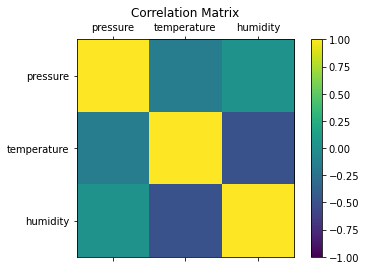

[Stage 6:>                                                          (0 + 1) / 1]

+--------------------+--------------------+--------------------+
|            pressure|         temperature|            humidity|
+--------------------+--------------------+--------------------+
|                 1.0|-0.16088514957990668|0.022755191813012228|
|-0.16088514957990668|                 1.0|-0.49711017460013535|
|0.022755191813012228|-0.49711017460013535|                 1.0|
+--------------------+--------------------+--------------------+



In [3]:
# 1. Realizar uma análise da correlação entre os atributos presentes na base de dados 
# (pressão, temperatura, umidade, P1 (PM10) e P2 (PM2,5)).

# Filtrando apenas as colunas desejadas
columns = ['pressure','temperature','humidity'] # faltando P1 e P2 no dataframe 
df_filtered = df.select(*columns)
df_filtered = df_filtered.filter(df_filtered.pressure.isNotNull())
df_filtered = df_filtered.filter(df_filtered.temperature.isNotNull())
df_filtered = df_filtered.filter(df_filtered.humidity.isNotNull())

# Criando coluna de vector
vector_column = "vector_column"
assembler = VectorAssembler(inputCols=df_filtered.columns, outputCol=vector_column)
df_vector = assembler.transform(df_filtered).select(vector_column)

# Obtendo matriz de correlação
matrix = Correlation.corr(df_vector, vector_column).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

# Plotando
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()
plot_corr_matrix(corrmatrix, columns, 234)

spark.createDataFrame(corrmatrix,columns).show() # testando